# DIGI405 Lab Class 8: Text classification

This week we will introduce text classification using scikit-learn. 

This is quite a long notebook. It will take you through loading and inspecting the texts in your corpus, setting up feature extraction, classifying your texts and evaluating your text classification model. You will need to jump around the notebook to change settings and rerun the classification to find good settings for feature extraction and to evaluate your model. 

**Important:** Each time you change settings below, you will need to rerun the cells that create the pipeline and does the classification.

<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task 0:</strong> Throughout the notebook there are defined tasks for you to do. Watch out for them - they will have a box around them like this! Make sure you take some notes as you go.
</div>

## Setup

Below we are importing required libraries. We will be using [scikit-learn](https://scikit-learn.org) for text classification in DIGI405. We will use the Naive Bayes Classifier. Scikit-learn has different feature extraction methods based on counts or tf-idf weights. We will also use NLTK for pre-processing.

In [ ]:
from wordcloud import WordCloud

In [30]:
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.datasets import fetch_20newsgroups

import numpy

import matplotlib.pyplot as plt

import re

import nltk
from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer 
from nltk.corpus import wordnet

Make sure you have the NLTK stopwords and the NLTK POS tagger (used by the NLTK lemmatiser).

In [31]:
# Stop words

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

stop_words = None
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
nltk_stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/allyhassell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/allyhassell/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [32]:
# Preview doc
def get_preview(docs, targets, target_names, doc_id, max_len=0):
    preview = ''
    if max_len < 1:
        preview += 'Label\n'
        preview += '=====\n'
    else:
        preview += str(doc_id)
        preview += '\t'
    preview += target_names[targets[doc_id]]
    if max_len < 1:
        preview += '\n\nFull Text\n'
        preview += '=========\n'
        preview += docs[doc_id]
        preview += '\n'
    else:
        excerpt = get_excerpt(docs[doc_id], max_len)
        preview += '\t' + excerpt
    return preview

_RE_COMBINE_WHITESPACE = re.compile(r"\s+")

# generate an excerpt
def get_excerpt(text, max_len):
    excerpt = _RE_COMBINE_WHITESPACE.sub(' ',text[0:max_len])
    if max_len < len(text):
        excerpt += '...'
    return excerpt.strip()

# combine a defined stop word list (or no stop word list) with any extra stop words defined
def set_stop_words(stop_word_list, extra_stop_words):
    if len(extra_stop_words) > 0:
        if stop_word_list is None:
            stop_word_list = []
        stop_words = list(stop_word_list) + extra_stop_words
    else:
        stop_words = stop_word_list
        
    return stop_words

# initiate stemming or lemmatising
def set_normaliser(normalise):
    if normalise == 'PorterStemmer':
        normaliser = PorterStemmer()
    elif normalise == 'SnowballStemmer':
        normaliser = SnowballStemmer('english')
    elif normalise == 'WordNetLemmatizer':
        normaliser = WordNetLemmatizer()
    else:
        normaliser = None
    return normaliser

# we are using a custom tokenisation process to allow different tokenisers and stemming/lemmatising ...
def tokenise(doc):
    global tokeniser, normalise, normaliser
    
    # you could obviously add more tokenisers here if you wanted ...
    if tokeniser == 'sklearn':
        tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b") # this is copied straight from sklearn source
        tokens = tokenizer.tokenize(doc)
    elif tokeniser == 'word_tokenize':
        tokens = word_tokenize(doc)
    elif tokeniser == 'wordpunct':
        tokens = wordpunct_tokenize(doc)
    else:
        tokens = word_tokenize(doc)
        
    # if using a normaliser then iterate through tokens and return the normalised tokens ...
    if normalise == 'PorterStemmer':
        return [normaliser.stem(t) for t in tokens]
    elif normalise == 'SnowballStemmer':
        return [normaliser.stem(t) for t in tokens]
    elif normalise == 'WordNetLemmatizer':
        # NLTK's lemmatiser needs parts of speech, otherwise assumes everything is a noun
        pos_tokens = nltk.pos_tag(tokens)
        lemmatised_tokens = []
        for token in pos_tokens:
            # NLTK's lemmatiser needs specific values for pos tags - this rewrites them ...
            # default to noun
            tag = wordnet.NOUN
            if token[1].startswith('J'):
                tag = wordnet.ADJ
            elif token[1].startswith('V'):
                tag = wordnet.VERB
            elif token[1].startswith('R'):
                tag = wordnet.ADV
            lemmatised_tokens.append(normaliser.lemmatize(token[0],tag))
        return lemmatised_tokens
    else:
        # no normaliser so just return tokens
        return tokens

## Preview stop word lists

As discussed in the lecture material, pre-processing can have a major influence on the results of text classification tasks. In particular, you should put thought into whether a stop word list is sensible for your task. The scikit-learn website also makes this point at https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words and recommends caution about using its stop word list! That page also links to a recent paper discussing practical issues with stop word lists, including whether the way you are tokenising your documents matches the tokenisation approach used in your stop word list.

Using the cells below you can preview the stop word lists supplied by scikit-learn and NLTK, which we have used previously in class. You will notice they are quite different.


<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task 1:</strong> For each stop word list, think of a text classification task where words in the stop word list could be informative and where it would be a bad idea to remove them.
</div>

In [33]:
print(sklearn_stop_words)

frozenset({'some', 'how', 'sometimes', 'been', 'neither', 'might', 'of', 'was', 'there', 'describe', 'from', 'do', 'both', 'seems', 'each', 'during', 'else', 'therein', 'back', 'is', 'yourselves', 'nothing', 'ourselves', 'indeed', 'give', 'whereafter', 'though', 'mine', 'take', 'since', 'hereafter', 'thereafter', 'made', 'a', 'sixty', 'are', 'mill', 'become', 'ten', 'only', 'these', 'within', 'which', 'anyhow', 'noone', 'they', 'once', 'why', 'ie', 'your', 'ours', 'system', 'behind', 'into', 'nor', 'keep', 'couldnt', 'up', 'will', 'still', 'three', 'because', 'inc', 'cannot', 'him', 'too', 'although', 'could', 'everything', 'already', 'go', 'own', 'find', 'all', 'onto', 'hasnt', 'throughout', 'me', 'please', 'herself', 'upon', 'becoming', 'bottom', 'five', 'until', 'anywhere', 'yet', 'where', 'afterwards', 'whereas', 'what', 'and', 'always', 'alone', 'hundred', 'about', 'amongst', 'due', 'very', 'off', 'show', 'fifty', 'the', 'meanwhile', 'their', 'co', 'may', 'such', 'seemed', 'part',

In [34]:
print(nltk_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Load corpus and set train/test split

Scikit-learn is packaged with a number of standard data-sets used in machine learning and provides a way to load other data. 
We will begin by loading texts from two categories in the [20 newsgroups dataset](http://qwone.com/~jason/20Newsgroups/) to work through an example classifying documents related to politics and religion.

What is a newsgroup? We are stretching back into internet history here - way before people talked to strangers on Facebook and Twitter and other social media, there were Usenet Newsgroups! [Here is a link to a Deja News page from 1998](https://web.archive.org/web/19980127204536/http://emarket.dejanews.com/emarket/about/idgs/aboutidgs.shtml) and also a [Wikipedia article](https://en.wikipedia.org/wiki/Usenet_newsgroup) that explains what Newsgroups are all about. 

This data-set was built from discussions between real people on the internet in the 1990s. Please be aware that within this data-set are texts that include racist, sexist, and other offensive language use. 

This cell also sets the train/test split. 80% of the data is used for training and 20% is used for testing. The documents are assigned to each group randomly. It can be useful to rerun this cell to reshuffle your dataset so you can evaluate your model using different data for training and testing.

In [35]:
# this chooses the categories to load
cats = ['talk.religion.misc', 'soc.religion.christian']

# this downloads/loads the data
dataset = fetch_20newsgroups(subset='train', categories=cats)
#dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=cats)

# assign the train/test split - 0.2 is 80% for training, 20% for testing
test_size = 0.2

# do the train test split ...
# docs_train and docs_test are the documents
# y_train and y_test are the labels
docs_train, docs_test, y_train, y_test = train_test_split(dataset.data, dataset.target, 
                                                          test_size = test_size, random_state=None)

In [36]:
dataset

{'data': ['From: rsteele@adam.ll.mit.edu (Rob Steele)\nSubject: Re: "Accepting Jeesus in your heart..."\nReply-To: rob@ll.mit.edu\nOrganization: MIT Lincoln Laboratory\nLines: 17\n\nIn article <Apr.10.05.32.36.1993.14391@athos.rutgers.edu>  \ngsu0033@uxa.ecn.bgu.edu (Eric Molas) writes:\n\n> We are _just_ animals.  We need sleep, food, and we reproduce.  And \n> we die.\n\nI agree we need sleep & etc, but I disagree we are _just_ animals.   \nThat statement is a categorical negative; it\'s like saying there are  \n_no_ polkadoted elephants.  It may be true but one would have to be  \nomniscient to know for sure.\n\n------------------------------------------------------------\nRob Steele                 In coming to understand anything \nMIT Lincoln Laboratory    we are rejecting the facts as they\n244 Wood St., M-203       are for us in favour of the facts\nLexington, MA  02173      as they are.    \n617/981-2575                              C.S. Lewis\n',
  'Subject: Re: After 2000 ye

## Inspect documents and labels

In the next cells we can look at the data we have imported. Firstly, we will preview the document labels and a brief excerpt.

In [38]:
for train_id in range(len(docs_train)):
    print(get_preview(docs_train, y_train, dataset.target_names, train_id, max_len=80))

0	soc.religion.christian	From: kene@acs.bu.edu (Kenneth Engel) Subject: Re: Why do people become atheists...
1	soc.religion.christian	From: jhpb@sarto.budd-lake.nj.us (Joseph H. Buehler) Subject: Re: SSPX schism ? ...
2	soc.religion.christian	From: jodfishe@silver.ucs.indiana.edu (joseph dale fisher) Subject: Re: Christia...
3	soc.religion.christian	From: tp0x+@cs.cmu.edu (Thomas Price) Subject: Re: Serbian genocide Work of God?...
4	soc.religion.christian	From: shellgate!llo@uu4.psi.com (Larry L. Overacker) Subject: Re: SSPX schism ? ...
5	talk.religion.misc	From: king@ctron.com (John E. King) Subject: Re: After 2000 years, can we say th...
6	soc.religion.christian	From: mdw33310@uxa.cso.uiuc.edu (Michael D. Walker) Subject: Re: Question about ...
7	talk.religion.misc	From: agr00@ccc.amdahl.com (Anthony G Rose) Subject: Re: Who's next? Mormons an...
8	talk.religion.misc	From: blowfish@leo.unm.edu (rON.) Subject: Re: 666, THE NUMBER OF THE BEAST, VIE...
9	talk.religion.misc	From: bobsa

You can use this cell to inspect a specific document and its label based on its index in the training set. Note: The indexes will change each time you import the data above because of the random train/test split.

<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task 2:</strong> Inspect some of the documents in each class and think about the kinds of words that might be useful features in this text classification task.
</div>

In [39]:
docs_train[0]

"From: kene@acs.bu.edu (Kenneth Engel)\nSubject: Re: Why do people become atheists?\nOrganization: Boston University, Boston, MA, USA\nLines: 32\n\nLet me tell you my story.\nI grew up catholic. Up until I was 14, it wasn't an issue for me. Then I met\na born-again christian, a very sweet person, not proseletyzing(sp?), not \nimposing. I tried to get into being as christian as I could, as I felt I \n'should'.\n\nBut the more I tried, the more depressed I got. I felt guilty for some of my\nown personal, honest feelings. I tried so hard to reconcile this conflict.\nuntil I was 23.\n\nThen I taught myself to think rationally. I read a lot of books, pro and con \nreligion in general and, specifically, catholicism. I came to a crisis point,\nthen it finally clicked and now I am a staunch atheist. \n\nThis is a very loose explanation, but it's the gist of it.\n\nNow, (at 26) I feel better about myself, better self-esteem, a generally \nstronger person. I have well-defined goals. I have a str

In [40]:
train_id = 11
print(get_preview(docs_train, y_train, dataset.target_names, train_id))

Label
=====
soc.religion.christian

Full Text
From: spebcg@thor.cf.ac.uk (BCG)
Subject: Re: Knowing God's Will
Organization: uwcc
Lines: 20

Hi,

I don't know much about Bible. Could you tell me the relations of
Christians with non-Christians in Bible? How should be The relations of
christian nations with each other and the relations of Christian nations
with other nations who are not Christians?

The other question is about the concept of religion in Bible. Does the
religion of God include and necessitate any law to be extracted from
Bible or is the religion only a belief and nothing to do with the
government sides? If for example, any government or a nation is one of
the wrongdoings according to Bible, how should they be treated? 

Is there any statement in Bible saying that Bible is a guide for every
aspects of life?  

Thank you.

Beytullah
 




## Preprocessing

This next section of the notebook steps you through some key kinds of pre-processing for text classification using Naive Bayes and a bag of words model. On the first run you should read about each setting, but leave the settings as they are. You will come back to this section to tune your model.

### Choose between token counts or tf-idf weights

You can choose between frequency for your bag of words or tf-idf weights. Valid values are:
```
Vectorizer = CountVectorizer
```
or
```
Vectorizer = TfidfVectorizer
```

In [41]:
Vectorizer = CountVectorizer

### Lowercase

Setting lowercase to True will transform all document text to lowercase. Setting it to False will not do this transformation.

In [42]:
lowercase = True

### Set how you are tokenising the text

With this notebook you can choose between the following tokenisers.

This option duplicates the behaviour of scikit-learn's default tokeniser: "The default regexp select tokens of 2 or more alphanumeric characters (punctuation is completely ignored and always treated as a token separator)". In this notebook we duplicate this behaviour using the NLTK's regular expression tokeniser and this regular expression: `r"(?u)\b\w\w+\b"`.
```
tokeniser = 'sklearn'
```
You can use this or specify one of the following tokenisers based on NLTK ...

Tokenise based on NLTK's wordpunct_tokenize tokeniser (to include words and punctuation!):
```
tokeniser = 'wordpunct'
```
This applies NLTK's word_tokenize tokeniser.
```
tokeniser = 'word_tokenize'
```

In [43]:
tokeniser = 'sklearn' 

### Stemming / Lemmatising

This allows to use NLTK stemmers or lemmatisers (or not). Valid options are shown below. Look for more information on the NLTK website: https://www.nltk.org/api/nltk.stem.html. Note: that stemming and lemmatising (in particular) will make the preprocessing take longer!

```
normalise = None
```
or
```
normalise = 'PorterStemmer'
```
or
```
normalise = 'SnowballStemmer'
```
or
```
normalise = 'WordNetLemmatizer'
```

In [44]:
normalise = None

### Configure stop words

Hopefully you have read the notes on stop word lists above and previewed the different lists. 

Do you want to apply a stop_word list? Valid values for stop_words below are:
```
stop_word_list = None
```
or
```
stop_word_list = nltk_stop_words
```
or
```
stop_word_list = sklearn_stop_words
```

In [45]:
stop_word_list = sklearn_stop_words

You can also add extra stop words to any of the lists above.
For example:
```
extra_stop_words = ['stopword1','stopword2','stopword3']
```
If you don't want extra stop words, then the next cell should look like:
```
extra_stop_words = []
```

In [46]:
extra_stop_words = []

### Filter features based on document frequency

The following values allow you to remove features that occur in many documents or in only a few documents.

Firstly, `min_df` ignores terms that occur below a minimum proportion of documents. For example, 0.01 would ignore terms that occur in less than 1% of documents.

In [47]:
min_df = 0.0

`max_df` allows you to ignore terms above a maximum proportion of documents. For example, 0.95 would ignore terms that occur in more than 95% of documents.

In [48]:
max_df = 1.0

### Set a maximum number of features

`max_features` set this to `None` for no limit or set to the maximum number of the most frequent features (e.g setting it to 1000 would use the 1000 most frequent features).

In [49]:
max_features = 1000

### Ngrams

With ngram_range set to (1,1) you will use unigrams as features i.e. each feature will be a token. If you set it to (1,2) you will use unigrams and bigrams. (1,3) will use unigrams, bigrams and trigrams. If you just want bigrams you would use (2,2). Please note: increasing the ngram range from (1,1) will add more time to preprocessing, as there will be more features.

In [50]:
ngram_range = (1,1)

### Encoding options

You can change the default encoding here and what to do if you get characters outside your default encoding.

In [51]:
encoding = 'utf-8'
decode_error = 'ignore' # what to do if contains characters not of the given encoding - options 'strict', 'ignore', 'replace'

## Setup the feature extraction and classification pipeline

This sets up a sci-kit learn pipeline that does feature extraction and classification. 

**Important Note 1:** When you change settings above or reload your dataset you should rerun this cell!

**Important Note 2:** This cell outputs the settings you used above, which you can cut and paste into a document to keep track of changes you are making and their effects.

In [58]:
# Task 4

# this chooses the categories to load
cats = ['talk.religion.misc', 'soc.religion.christian']

# this downloads/loads the data
#dataset = fetch_20newsgroups(subset='train', categories=cats)
dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=cats)

# assign the train/test split - 0.2 is 80% for training, 20% for testing
test_size = 0.2

# do the train test split ...
# docs_train and docs_test are the documents
# y_train and y_test are the labels
docs_train, docs_test, y_train, y_test = train_test_split(dataset.data, dataset.target, 
                                                          test_size = test_size, random_state=None)

In [59]:
# you shouldn't need to change anything in this cell!

stop_words = set_stop_words(stop_word_list, extra_stop_words)
normaliser = set_normaliser(normalise)

pipeline = Pipeline([
    ('vectorizer', Vectorizer(
            tokenizer = tokenise,
            lowercase = lowercase,
            min_df = min_df, 
            max_df = max_df, 
            max_features = max_features,
            stop_words = stop_words, 
            ngram_range = ngram_range,
            encoding = encoding, 
            decode_error = decode_error)),
    ('classifier', MultinomialNB()), #here is where you would specify an alternative classifier
])

print('Classifier settings')
print('===================')
print('classifier:', type(pipeline.steps[1][1]).__name__)
print('vectorizer:', type(pipeline.steps[0][1]).__name__)
print('classes:', dataset.target_names)
print('lowercase:', lowercase)
print('tokeniser:', tokeniser)
print('normalise:', normalise)
print('min_df:', min_df)
print('max_df:', max_df)
print('max_features:', max_features)
if stop_word_list == nltk_stop_words:
    print('stop_word_list:', 'nltk_stop_words')
elif stop_word_list == sklearn_stop_words:
    print('stop_word_list:', 'sklearn_stop_words')
else:
    print('stop_word_list:', 'None')
print('extra_stop_words:', extra_stop_words)
print('ngram_range:', ngram_range)
print('encoding:', encoding)
print('decode_error:', decode_error)

Classifier settings
classifier: MultinomialNB
vectorizer: CountVectorizer
classes: ['soc.religion.christian', 'talk.religion.misc']
lowercase: True
tokeniser: sklearn
normalise: None
min_df: 0.0
max_df: 0.98
max_features: 1100
stop_word_list: sklearn_stop_words
extra_stop_words: []
ngram_range: (1, 1)
encoding: utf-8
decode_error: ignore


## Train the classifier and predict labels on test data

This cell does the work of training the classifier and predicting labels on test data. It also outputs evaluation metrics, a confusion matrix and features indicative of each class.

**Important Note:** You can cut and paste the model output into a document (with the settings above) to keep track of changes you are making and their effects.

Evaluation metrics
                        precision    recall  f1-score   support

soc.religion.christian       0.76      0.85      0.80       114
    talk.religion.misc       0.75      0.62      0.68        82

              accuracy                           0.76       196
             macro avg       0.75      0.74      0.74       196
          weighted avg       0.75      0.76      0.75       196



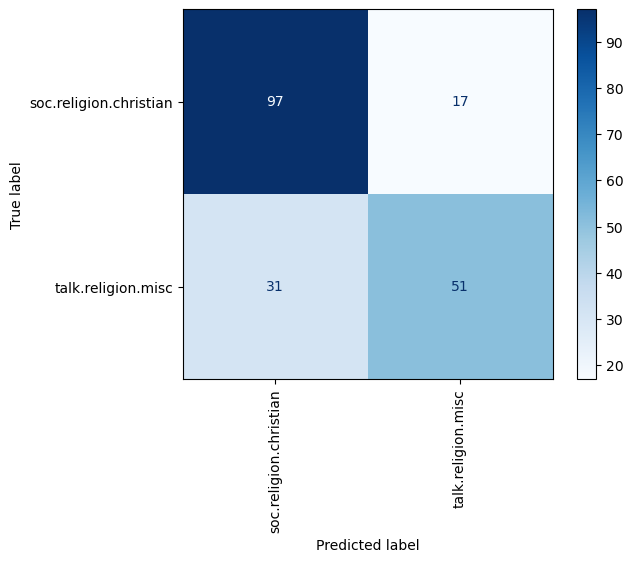


Features most indicative of soc.religion.christian
easter maria liturgy infallible specific judgement differences schism unity married marriage coptic role timothy archbishop clh darren mary passion moderator 

Features most indicative of talk.religion.misc
tyre lds fbi brian db ra decenso hanging zoroastrians caligiuri hare hudson weiss archer plane mcconkie southern kent morality cheers 

/Users/allyhassell/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [60]:
# you shouldn't need to change anything in this cell!

pipeline.fit(docs_train, y_train)
y_predicted = pipeline.predict(docs_test)

# print report
print('Evaluation metrics')
print('==================')
print(metrics.classification_report(y_test, y_predicted, target_names = dataset.target_names))
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_predicted, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.target_names)
disp = disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='vertical')
plt.show()

vect = pipeline.steps[0][1]
clf = pipeline.steps[1][1]

print()

logodds=clf.feature_log_prob_[1]-clf.feature_log_prob_[0]

print("Features most indicative of",dataset.target_names[0])
print('============================' + '='*len(dataset.target_names[0]))
for i in numpy.argsort(logodds)[:20]:
    print(vect.get_feature_names()[i], end=' ')
print()
print()

print("Features most indicative of",dataset.target_names[1])
print('============================' + '='*len(dataset.target_names[1]))
for i in numpy.argsort(-logodds)[:20]:
    print(vect.get_feature_names()[i], end=' ')
    
lookup = dict((v,k) for k,v in vect.vocabulary_.items())

In [54]:
Vectorizer = CountVectorizer
lowercase = True
tokeniser = 'sklearn' # wordpunct word_tokenize sklearn
normalise = None
stop_word_list = sklearn_stop_words # sklearn_stop_words nltk_stop_words sklearn_stop_words nltk_stop_words
extra_stop_words = []
min_df = 0.0
max_df = 0.98
max_features = 1100
ngram_range = (1,1)
encoding = 'utf-8'
decode_error = 'ignore' 

In [55]:
# you shouldn't need to change anything in this cell!

stop_words = set_stop_words(stop_word_list, extra_stop_words)
normaliser = set_normaliser(normalise)

pipeline = Pipeline([
    ('vectorizer', Vectorizer(
            tokenizer = tokenise,
            lowercase = lowercase,
            min_df = min_df, 
            max_df = max_df, 
            max_features = max_features,
            stop_words = stop_words, 
            ngram_range = ngram_range,
            encoding = encoding, 
            decode_error = decode_error)),
    ('classifier', MultinomialNB()), #here is where you would specify an alternative classifier
])

print('Classifier settings')
print('===================')
print('classifier:', type(pipeline.steps[1][1]).__name__)
print('vectorizer:', type(pipeline.steps[0][1]).__name__)
print('classes:', dataset.target_names)
print('lowercase:', lowercase)
print('tokeniser:', tokeniser)
print('normalise:', normalise)
print('min_df:', min_df)
print('max_df:', max_df)
print('max_features:', max_features)
if stop_word_list == nltk_stop_words:
    print('stop_word_list:', 'nltk_stop_words')
elif stop_word_list == sklearn_stop_words:
    print('stop_word_list:', 'sklearn_stop_words')
else:
    print('stop_word_list:', 'None')
print('extra_stop_words:', extra_stop_words)
print('ngram_range:', ngram_range)
print('encoding:', encoding)
print('decode_error:', decode_error)

Classifier settings
classifier: MultinomialNB
vectorizer: CountVectorizer
classes: ['soc.religion.christian', 'talk.religion.misc']
lowercase: True
tokeniser: sklearn
normalise: None
min_df: 0.0
max_df: 0.98
max_features: 1100
stop_word_list: sklearn_stop_words
extra_stop_words: []
ngram_range: (1, 1)
encoding: utf-8
decode_error: ignore


In [ ]:
# Lowercase = False improves 

## List all features

Just for your reference here is a count and list of all features used in this model.

In [56]:
print('Total Features: ',len(vect.get_feature_names()))
print(vect.get_feature_names())

Total Features:  1000
['00', '01', '02', '03', '05', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1993', '20', '2000', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '38', '40', '41', '44', '93', 'ability', 'able', 'abortion', 'absolute', 'absolutely', 'absolutes', 'ac', 'accept', 'accepted', 'accepting', 'access', 'according', 'account', 'accounts', 'acs', 'act', 'action', 'actions', 'activities', 'acts', 'actually', 'ad', 'adam', 'add', 'address', 'admit', 'age', 'ago', 'agree', 'ai', 'aids', 'alicea', 'alink', 'alive', 'allow', 'allowed', 'alt', 'american', 'ancient', 'andrew', 'angels', 'animals', 'answer', 'answers', 'anti', 'apostle', 'apostles', 'appear', 'appears', 'apple', 'applied', 'apply', 'approach', 'apr', 'area', 'aren', 'argument', 'arguments', 'arizona', 'arrogance', 'arrogant', 'article', 'articles', 'aside', 'ask', 'asked', 'asking', 'association', 'assume', 'assumption', 'atheist', 'atheists', 'athena', 'ath

## Comments about the results on your first run of this notebook (with defaults)

You've probably got something > 0.9 for accuracy. This is pretty good! However, we should ask "why?"!

## Inspect correctly/incorrectly classified documents

The output in the next cell is quite long and will take a few moments to generate. It will show you wordclouds and a preview of documents for correctly and incorrectly classified documents. The size of words in the wordclouds are based on adding up counts/tf-idf scores of features based on documents related to each cell in the confusion matrix 

In [57]:
# setup a counter for each cell in the confusion matrix
counter = {}
previews = {}
for true_target, target_name in enumerate(dataset.target_names):
    counter[true_target] = {}
    previews[true_target] = {}
    for predicted_target, target_name in enumerate(dataset.target_names):
        counter[true_target][predicted_target] = {}
        previews[true_target][predicted_target] = ''

# get doc-term matrix for test docs
doc_terms = vect.transform(docs_test)

# iterate through all predictions, building the counter and preview of docs
# there is a better way to do this, but this will do!
for doc_id, prediction in enumerate(clf.predict(doc_terms)):
    for k, v in enumerate(doc_terms[doc_id].toarray()[0]):
        if v > 0:
            if lookup[k] not in counter[y_test[doc_id]][prediction]:
                counter[y_test[doc_id]][prediction][lookup[k]] = 0
            counter[y_test[doc_id]][prediction][lookup[k]] += v
    
    previews[y_test[doc_id]][prediction] += get_preview(docs_test, y_test, dataset.target_names, doc_id, max_len=80) + '\n'

# output a wordcloud and preview of docs for each cell of confusion matrix ...
for true_target, target_name in enumerate(dataset.target_names):
    for predicted_target, target_name in enumerate(dataset.target_names):
        if true_target == predicted_target:
            print(dataset.target_names[true_target],'Correctly classified')
        else:
            print(dataset.target_names[true_target],'incorrectly classified as',dataset.target_names[predicted_target])
        print('=================================================================')

        wordcloud = WordCloud(background_color="white", width=800, height=600, color_func=lambda *args, **kwargs: "black").generate_from_frequencies(counter[true_target][predicted_target])
        plt.figure(figsize=(16, 8), dpi= 600)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()        
        
        print(previews[true_target][predicted_target])



soc.religion.christian Correctly classified


NameError: name 'WordCloud' is not defined

## Preview document and its features

Use this cell to preview a document using its index in the test set. You can see the predicted label, its actual label, the full text and the features for this specific document.

<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task 3:</strong> Inspect documents that were correct and incorrectly classified. Loaded question: Are there features that are not related to the topics that are making it easier for the model to predict the class? (Hint: this is a "loaded question" because the answer is yes!).
</div>

In [164]:
for i in range(0,10):
    test_id = i
    pred = dataset.target_names[clf.predict(vect.transform([docs_test[test_id]]))[0]]
    lab = dataset.target_names[clf.predict(vect.transform([docs_test[test_id]]))[0]]
    if pred != lab:
        print('Prediction')
        print(pred)
        print('Label')
        print(lab)
        


Prediction
sci.space
Label
Label
=====
sci.space

Full Text
From: wats@scicom.AlphaCDC.COM (Bruce Watson)
Subject: Re: First Spacewalk
Distribution: sci
Organization: Alpha Science Computer Network, Denver, Co.
Lines: 13

In article <C5suMG.2rF.1@cs.cmu.edu+ flb@flb.optiplan.fi ("F.Baube[tm]") writes:
+At one time there was speculation that the first spacewalk 
+(Alexei Leonov ?) was a staged fake.
+
+Has any evidence to support or contradict this claim emerged ?
+
+Was this claim perhaps another fevered Cold War hallucination ?

I, for one, would be an avid reader of a sci.space.ussr.what.really.
happened.

-- 
Bruce Watson (wats@scicom.alphaCDC.COM) Bulletin 629-49 Item 6700 Extract 75,131


Prediction
sci.space
Label
Label
=====
sci.space

Full Text
From: baalke@kelvin.jpl.nasa.gov (Ron Baalke)
Subject: JPL's VLBI Project Meets with International Space Agencies
Organization: Jet Propulsion Laboratory
Lines: 112
Distribution: world
NNTP-Posting-Host: kelvin.jpl.nasa.gov
Keywords: VLB

## Answer: Why this classification task is perhaps easier than it should be!

You will notice features like edu, com, and other portions of email addresses, as well as names that appear in the headers of these newsgroup messages. The information in message headers, as well as footers and quoted material means that the classification task is focused on metadata of the messages rather than the topics themselves. If we are interested in topic-based classifications, features like people's email addresses (who perhaps post often in a newsgroup) are not good signals. To make this more interesting and more challenging for the rest of the lab we need to load the data with just the message text itself. 

## Classifying based on the "text"

<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task 4:</strong> Return to the cell where you loaded the corpus and comment out the line that loads all the data and uncomment the line that loads the messages without headers, footers and quotes. It should look like this after you make the change:
    <pre>
# this downloads/loads the data
# dataset = fetch_20newsgroups(subset='train', categories=cats)
dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=cats)</pre>
</div>

<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task 5:</strong> If you haven't already re-run the cell that loads the data and then run the other cells to classify the texts. Note that your accuracy has decreased.     
</div>

<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task 6:</strong> Now we really get into the task of classifying the texts! You can change the settings to try different feature extraction/pre-processing. Pay attention to the way that preprocessing affects the results. Make sure you evaluate your model and inspect the output as you go. Keep notes on what you observe. Once you have improved the accuracy of your model chat to your tutor and also check the Online Text Classification Task on Learn!
</div>

<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task 7:</strong> What documents are the most difficult to classify and why?! Is it to do with specific documents? Or, is it about the classes and the kind of talk that appears in them? Are there certain sub topics that are challenging?
</div>

<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task 8:</strong> Carefully read through the instructions for the Online Text Classification Task on Week 9 of Learn (under the Participation Task heading). You can start on the Online Text Classification Task whenever you like.
</div>

In [43]:
# Task 4

# this chooses the categories to load
cats = ['talk.religion.misc', 'soc.religion.christian']

# this downloads/loads the data
#dataset = fetch_20newsgroups(subset='train', categories=cats)
dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=cats)

# assign the train/test split - 0.2 is 80% for training, 20% for testing
test_size = 0.2

# do the train test split ...
# docs_train and docs_test are the documents
# y_train and y_test are the labels
docs_train, docs_test, y_train, y_test = train_test_split(dataset.data, dataset.target, 
                                                          test_size = test_size, random_state=None)